# Analyzing Arsenal clutch goals
A goal scored is worth one goal, but we all know there are goals that means more either because of the significance of the goal, the way it was scored and a combination of other factors.

Arsenal scored 112 goals last season - here we will rank the top 10 goals based on 'clutch score', a metric that assigns weighted score for how significant a goal is. A last minute goal to complete a comeback? Clutch. Scoring a wonderful free-kick in a Champions League tie against the defending champion? Clutch. Scoring the sixth goal in a drubbing against the league's bottom team? Not as clutch.

The formula for this ranking is as follows:
- Every goal is tagged with either one of first goal (worth 2 points), equalizer (3 points), go-ahead goal (4 points), winning goal (5 points), or other (1 point)
- From there we add three other additional factors: the opponent (top level opponents are worth 3 points, league one side is worth a point), the competition (Champions League > EFL Cup), and the context (playing with 10-men away from home and scoring a late winner is worth three points, a routine win against bottom of the league side is worth one point).
- There are also some bonus points added based on my discretion.

In [1]:
# Import the required libraries

# Supabase is where the data is stored
import supabase
from supabase import create_client, Client
# Pandas to convert the supabase query to a dataframe
import pandas as pd
# These libraries help in adding visual elements in the data visualization (club crest and nation flags)
import matplotlib.pyplot as plt
from PIL import Image
import urllib
import os

## Load the data
We need a data on all of Arsenal's goals this season, so first we access the match events table from Supabase.
Then, we merge them with data from the players table (also from Supabase). We also load data of all goals in Arsenal's matches in order to proerly tagged the goals.

In [2]:
# Access this season's data from Supabase
# Provide the URL and key to the Supabase project - store it in 'url' and 'key'
url = 'Your Supabase Project URL'
key = 'Your Supabase Project Key'

# Create a supabase client
supabase: Client = create_client(url, key)

In [3]:
# Get goals data from the 'match_events' table - only for Arsenal ('team_id' == 13)
response = supabase.table('match_events') \
    .select('*') \
    .eq('team_id', 13) \
    .eq('type_display_name', 'Goal') \
    .execute()

# Save the output to a pandas dataframe
df_goals = pd.DataFrame(response.data)

# Preview the data
df_goals.head(10)

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name
0,2768790363,1821405,629,73,34,13,386519,89.2,65.2,None,...,None,None,7.0,46.1,True,False,True,Goal,Successful,SecondHalf
1,2760438465,1871163,570,53,16,13,279379,93.3,37.9,None,...,None,None,8.9,46.4,True,False,True,Goal,Successful,SecondHalf
2,2760449207,1871163,790,72,21,13,279379,92.3,35.6,None,...,None,None,8.2,53.7,True,False,True,Goal,Successful,SecondHalf
3,2760453381,1871163,842,80,10,13,279379,89.9,39.1,None,...,None,None,5.7,52.3,True,False,True,Goal,Successful,SecondHalf
4,2763102463,1821280,286,28,23,13,279379,94.6,47.2,None,...,None,None,22.8,49.4,True,False,True,Goal,Successful,FirstHalf
5,2763108261,1821280,508,49,18,13,238916,97.5,47.4,None,...,None,None,19.0,52.0,True,False,True,Goal,Successful,SecondHalf
6,2763108905,1821280,543,52,26,13,380706,88.2,58.7,None,...,None,None,14.6,46.1,True,False,True,Goal,Successful,SecondHalf
7,2766613731,1821317,304,34,8,13,380706,95.8,46.0,None,...,None,None,18.4,48.3,True,False,True,Goal,Successful,FirstHalf
8,2766635065,1821317,493,54,35,13,326413,91.8,55.5,None,...,None,None,7.0,47.4,True,False,True,Goal,Successful,SecondHalf
9,2757027057,1821194,535,51,52,13,361822,97.3,51.1,None,...,None,None,5.7,49.7,True,False,True,Goal,Successful,SecondHalf


In [4]:
# Query the players' data from 'player' table
response = supabase.table('player').select('*').eq('team_id', 13).execute()

# Save the output to a Pandas dataframe
df_players = pd.DataFrame(response.data)

# Preview the players data
df_players.head(10)

,player_id,shirt_no,name,position,age,team_id
0,489986,36,Tommy Setford,Sub,19,13
1,534234,62,Alexei Rojas,Sub,19,13
2,427103,56,Salah-Eddine Oulad M'hand,Sub,21,13
3,540048,92,Jack Porter,Sub,16,13
4,539715,47,Maldini Kacurri,Sub,19,13
5,539716,46,Ismeal Kabia,Sub,19,13
6,467917,50,Zane Monlouis,Sub,21,13
7,541016,61,Josh Robinson,Sub,20,13
8,377283,18,Takehiro Tomiyasu,Sub,26,13
9,386519,33,Riccardo Calafiori,Sub,23,13


In [5]:
# Merge the two dataframes
df_goals = df_goals.merge(df_players, how="left", on="player_id")

In [6]:
# Drop the 'team_id_y' column as it's redundant
df_goals = df_goals.drop(['id', 'team_id_y'], axis=1)
# Preview the dataframe after merging
df_goals.head(10)

,match_id,event_id,minute,second,team_id_x,player_id,x,y,end_x,end_y,...,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,shirt_no,name,position,age
0,1821405,629,73,34,13,386519,89.2,65.2,None,None,...,True,False,True,Goal,Successful,SecondHalf,33,Riccardo Calafiori,Sub,23
1,1871163,570,53,16,13,279379,93.3,37.9,None,None,...,True,False,True,Goal,Successful,SecondHalf,9,Gabriel Jesus,Sub,27
2,1871163,790,72,21,13,279379,92.3,35.6,None,None,...,True,False,True,Goal,Successful,SecondHalf,9,Gabriel Jesus,Sub,27
3,1871163,842,80,10,13,279379,89.9,39.1,None,None,...,True,False,True,Goal,Successful,SecondHalf,9,Gabriel Jesus,Sub,27
4,1821280,286,28,23,13,279379,94.6,47.2,None,None,...,True,False,True,Goal,Successful,FirstHalf,9,Gabriel Jesus,Sub,27
5,1821280,508,49,18,13,238916,97.5,47.4,None,None,...,True,False,True,Goal,Successful,SecondHalf,23,Mikel Merino,FW,28
6,1821280,543,52,26,13,380706,88.2,58.7,None,None,...,True,False,True,Goal,Successful,SecondHalf,11,Gabriel Martinelli,FWL,23
7,1821317,304,34,8,13,380706,95.8,46.0,None,None,...,True,False,True,Goal,Successful,FirstHalf,11,Gabriel Martinelli,FWL,23
8,1821317,493,54,35,13,326413,91.8,55.5,None,None,...,True,False,True,Goal,Successful,SecondHalf,29,Kai Havertz,Sub,25
9,1821194,535,51,52,13,361822,97.3,51.1,None,None,...,True,False,True,Goal,Successful,SecondHalf,2,William Saliba,DC,24


In [7]:
# Query match events table for all goals - eq('type_display_name', 'Goal'). 
# We need this data to properly tag whether a goal is the first goal, an equalizer, or a winning goal.
response = supabase.table('match_events') \
    .select('*') \
    .eq('type_display_name', 'Goal') \
    .execute()
# Save the query into a Pandas dataframe
df_all_goals = pd.DataFrame(response.data)

# Data Processing
We want to tag every goal with either one of:
- First goal (first goal of the match)
- Equalizer (a goal that brings Arsenal level)
- Go ahead (a goal that gives Arsenal the lead)
- Winning goal (a goal that gives Arsenal the lead from which they didn't relinquish)
- Other (additional goal after the winning goal, consolation goal in a defeat)

We will also clean the players dataframe and merged it with the goals dataframe to create a complete dataset.

In [8]:
# Create a function to tag every goals
# The tags are: first_goal, equalizer, go_ahead, late_goal, winning_goal, and other

def tag_clutch_goals(df_goals: pd.DataFrame, df_all_goals: pd.DataFrame, arsenal_team_id: int = 13):
    df_all_goals = df_all_goals.sort_values(by=['match_id', 'minute', 'second']).copy()
    tagged_goals = []

    for match_id in df_all_goals['match_id'].unique():
        match_goals = df_all_goals[df_all_goals['match_id'] == match_id].copy()
        match_goals['is_arsenal'] = match_goals['team_id'] == arsenal_team_id

        home_goals = 0
        away_goals = 0
        arsenal_goal_events = []

        for i, row in match_goals.iterrows():
            current_team = row['team_id']
            is_arsenal = current_team == arsenal_team_id
            tags = []

            current_team_score = home_goals if is_arsenal else away_goals
            opponent_team_score = away_goals if is_arsenal else home_goals

            # Tag: first_goal
            if home_goals + away_goals == 0 and is_arsenal:
                tags.append('first_goal')

            # Tag: equalizer
            if is_arsenal and current_team_score + 1 == opponent_team_score:
                tags.append('equalizer')

            # Tag: go_ahead (from draw or behind)
            if is_arsenal and current_team_score == opponent_team_score:
                tags.append('go_ahead')

            # Tag: late_goal
            if is_arsenal and row['minute'] >= 80:
                tags.append('late_goal')

            # Update goal counts
            if current_team == arsenal_team_id:
                home_goals += 1
            else:
                away_goals += 1

            # Store Arsenal goal events
            if is_arsenal:
                arsenal_goal_events.append((row, tags))

        # Final score determination
        arsenal_goals = home_goals if arsenal_team_id == 13 else away_goals
        opponent_goals = away_goals if arsenal_team_id == 13 else home_goals
        arsenal_win = arsenal_goals > opponent_goals

        # Tag: winning_goal
        if arsenal_win:
            # Final winning score
            winning_goal_number = opponent_goals + 1
            goal_count = 0
            for idx, (row, tags) in enumerate(arsenal_goal_events):
                goal_count += 1
                if goal_count == winning_goal_number:
                    tags.append('winning_goal')
                if not tags and (arsenal_goals - opponent_goals) >= 2:
                    tags.append('other')
                new_row = row.copy()
                new_row['tags'] = tags
                tagged_goals.append(new_row)
        else:
            # No win: just assign 'other' if needed
            for row, tags in arsenal_goal_events:
                if not tags:
                    tags.append('other')
                new_row = row.copy()
                new_row['tags'] = tags
                tagged_goals.append(new_row)

    df_tagged = pd.DataFrame(tagged_goals)
    return df_tagged

In [9]:
# Apply the goal tagging function to the dataframe
df_tagged_goals = tag_clutch_goals(df_goals, df_all_goals, arsenal_team_id=13)

In [10]:
# Preview the dataset after running the tagging function
df_tagged_goals[['match_id', 'minute', 'tags']]

,match_id,minute,tags
112,1821052,24,"[first_goal, go_ahead, winning_goal]"
113,1821052,73,[other]
30,1821060,66,"[first_goal, go_ahead, winning_goal]"
31,1821060,76,[other]
66,1821069,37,"[first_goal, go_ahead]"
...,...,...,...
132,1894555,69,[other]
133,1894555,74,[other]
158,1894556,64,"[first_goal, go_ahead]"
160,1894556,92,"[go_ahead, late_goal, winning_goal]"


In [11]:
# The tagged goals dataframe does not have a player name column - merge it with the 'df_players' dataframe to get player names

df_tagged_goals = df_tagged_goals.merge(df_players[['player_id', 'name', 'age']],
                                        how="left", on="player_id")

In [12]:
# Preview the data have all the correct columns
df_tagged_goals

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_arsenal,tags,name,age
0,2709693243,1821052,237,24,31,13,326413,92.3,49.6,None,...,True,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Kai Havertz,25
1,2709788791,1821052,663,73,5,13,367185,86.9,29.6,None,...,True,False,True,Goal,Successful,SecondHalf,True,[other],Bukayo Saka,23
2,2712675873,1821060,619,66,48,13,113994,88.1,56.6,None,...,True,False,True,Goal,Successful,SecondHalf,True,"[first_goal, go_ahead, winning_goal]",Leandro Trossard,30
3,2712687863,1821060,731,76,53,13,238940,81.2,40.3,None,...,True,False,True,Goal,Successful,SecondHalf,True,[other],Thomas Partey,31
4,2715288557,1821069,302,37,59,13,326413,78.5,54.1,None,...,True,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead]",Kai Havertz,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2798395083,1894555,621,69,46,13,332325,76.9,62.0,None,...,True,False,True,Goal,Successful,SecondHalf,True,[other],Declan Rice,26
108,2798398753,1894555,646,74,29,13,238916,84.4,47.2,None,...,True,False,True,Goal,Successful,SecondHalf,True,[other],Mikel Merino,28
109,2801982285,1894556,461,64,37,13,367185,92.0,58.7,None,...,True,False,True,Goal,Successful,SecondHalf,True,"[first_goal, go_ahead]",Bukayo Saka,23
110,2801989091,1894556,639,92,29,13,380706,88.9,59.7,None,...,True,False,True,Goal,Successful,SecondHalf,True,"[go_ahead, late_goal, winning_goal]",Gabriel Martinelli,23


In [13]:
# Assign weighted score for each tags
tag_weights = {
    'winning_goal': 5,
    'first_goal': 2,
    'equalizer': 3,
    'go_ahead': 4,
    'late_goal': 1,
    'other': 1
}

# Create a function to calculate the score for each goals based on the weighted score
def compute_goal_score(tags):
    return sum(tag_weights.get(tag, 0) for tag in tags)

In [14]:
# Apply the score function to the dataframe
df_tagged_goals['clutch_score'] = df_tagged_goals['tags'].apply(compute_goal_score)
# preview the first 10 rows of data
df_tagged_goals.head(10)

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_arsenal,tags,name,age,clutch_score
0,2709693243,1821052,237,24,31,13,326413,92.3,49.6,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Kai Havertz,25,11
1,2709788791,1821052,663,73,5,13,367185,86.9,29.6,None,...,False,True,Goal,Successful,SecondHalf,True,[other],Bukayo Saka,23,1
2,2712675873,1821060,619,66,48,13,113994,88.1,56.6,None,...,False,True,Goal,Successful,SecondHalf,True,"[first_goal, go_ahead, winning_goal]",Leandro Trossard,30,11
3,2712687863,1821060,731,76,53,13,238940,81.2,40.3,None,...,False,True,Goal,Successful,SecondHalf,True,[other],Thomas Partey,31,1
4,2715288557,1821069,302,37,59,13,326413,78.5,54.1,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead]",Kai Havertz,25,6
5,2720886921,1821083,462,63,43,13,334087,96.1,49.7,None,...,False,True,Goal,Successful,SecondHalf,True,"[first_goal, go_ahead, winning_goal]",Gabriel Magalhães,27,11
6,2724481055,1821096,104,21,14,13,386519,79.1,69.9,None,...,False,True,Goal,Successful,FirstHalf,True,[equalizer],Riccardo Calafiori,23,3
7,2724505797,1821096,260,45,4,13,334087,98.2,53.6,None,...,False,True,Goal,Successful,FirstHalf,True,[go_ahead],Gabriel Magalhães,27,4
8,2726991019,1821100,248,19,10,13,380706,87.2,51.0,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead]",Gabriel Martinelli,23,6
9,2727052563,1821100,576,45,43,13,113994,90.6,55.7,None,...,False,True,Goal,Successful,FirstHalf,True,[other],Leandro Trossard,30,1


In [15]:
# Sort the data in descending order (top 10 only)
df_tagged_goals.sort_values(by='clutch_score', ascending=False).head(10)

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_arsenal,tags,name,age,clutch_score
65,2776325981,1821420,788,80,11,13,238916,93.2,51.8,None,...,False,True,Goal,Successful,SecondHalf,True,"[first_goal, go_ahead, late_goal, winning_goal]",Mikel Merino,28,12
0,2709693243,1821052,237,24,31,13,326413,92.3,49.6,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Kai Havertz,25,11
18,2789218331,1821171,187,19,34,13,238916,95.8,39.7,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Mikel Merino,28,11
49,2803887377,1821346,198,13,41,13,113994,89.2,46.0,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Leandro Trossard,30,11
59,2768790363,1821405,629,73,34,13,386519,89.2,65.2,None,...,False,True,Goal,Successful,SecondHalf,True,"[first_goal, go_ahead, winning_goal]",Riccardo Calafiori,23,11
44,2750515739,1821321,127,14,6,13,367185,86.8,56.8,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Bukayo Saka,23,11
36,2762464403,1821265,332,22,23,13,326413,96.9,46.8,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Kai Havertz,25,11
72,2729219663,1866166,168,19,20,13,326413,94.3,47.0,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Kai Havertz,25,11
33,2755409017,1821232,467,53,2,13,388650,98.0,57.5,None,...,False,True,Goal,Successful,SecondHalf,True,"[first_goal, go_ahead, winning_goal]",Jurriën Timber,23,11
74,2767895637,1866188,31,1,45,13,332325,89.5,60.7,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Declan Rice,26,11


In [16]:
# Remove goals scored in penalty shootout - these goals aren't part of the analysis
df_tagged_goals_normal = df_tagged_goals[df_tagged_goals['period_display_name'] != 'PenaltyShootout']

In [17]:
df_tagged_goals_normal

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_arsenal,tags,name,age,clutch_score
0,2709693243,1821052,237,24,31,13,326413,92.3,49.6,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead, winning_goal]",Kai Havertz,25,11
1,2709788791,1821052,663,73,5,13,367185,86.9,29.6,None,...,False,True,Goal,Successful,SecondHalf,True,[other],Bukayo Saka,23,1
2,2712675873,1821060,619,66,48,13,113994,88.1,56.6,None,...,False,True,Goal,Successful,SecondHalf,True,"[first_goal, go_ahead, winning_goal]",Leandro Trossard,30,11
3,2712687863,1821060,731,76,53,13,238940,81.2,40.3,None,...,False,True,Goal,Successful,SecondHalf,True,[other],Thomas Partey,31,1
4,2715288557,1821069,302,37,59,13,326413,78.5,54.1,None,...,False,True,Goal,Successful,FirstHalf,True,"[first_goal, go_ahead]",Kai Havertz,25,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2798395083,1894555,621,69,46,13,332325,76.9,62.0,None,...,False,True,Goal,Successful,SecondHalf,True,[other],Declan Rice,26,1
108,2798398753,1894555,646,74,29,13,238916,84.4,47.2,None,...,False,True,Goal,Successful,SecondHalf,True,[other],Mikel Merino,28,1
109,2801982285,1894556,461,64,37,13,367185,92.0,58.7,None,...,False,True,Goal,Successful,SecondHalf,True,"[first_goal, go_ahead]",Bukayo Saka,23,6
110,2801989091,1894556,639,92,29,13,380706,88.9,59.7,None,...,False,True,Goal,Successful,SecondHalf,True,"[go_ahead, late_goal, winning_goal]",Gabriel Martinelli,23,10


In [18]:
# Prepare a dataframe that shows all of Arsenal's goalscorers
all_scorers = (
    df_tagged_goals_normal.groupby('name')
    .size()
    .reset_index(name='goals')
    .sort_values('goals', ascending=False)
)
# Preview the output
all_scorers

,name,goals
9,Kai Havertz,15
0,Bukayo Saka,12
5,Gabriel Martinelli,10
11,Leandro Trossard,10
2,Ethan Nwaneri,9
13,Mikel Merino,9
1,Declan Rice,9
3,Gabriel Jesus,7
12,Martin Ødegaard,6
4,Gabriel Magalhães,5


In [19]:
# Create a position list for every Arsenal player that scored at least one goal this season

DF = ['Gabriel Magalhães', 'Riccardo Calafiori', 'William Saliba', 'Jurriën Timber', 
      'Myles Lewis-Skelly', 'Oleksandr Zinchenko', 'Jakub Kiwior', 'Kieran Tierney']
MF = ['Jorginho', 'Thomas Partey', 'Martin Ødegaard', 'Declan Rice', 'Mikel Merino']
FW = ['Kai Havertz', 'Bukayo Saka', 'Gabriel Martinelli', 'Leandro Trossard', 
      'Ethan Nwaneri', 'Gabriel Jesus', 'Raheem Sterling']

In [20]:
# Write a position assignment function
def assign_position(name):
    if name in DF:
        return 'DF'
    elif name in MF:
        return 'MF'
    elif name in FW:
        return 'FW'
    else:
        return 'Unknown'

# Count goals and include age
all_scorers = (
    df_tagged_goals_normal.groupby(['name', 'age'])
    .size()
    .reset_index(name='goals')
)

# Add position column
all_scorers['position'] = all_scorers['name'].apply(assign_position)

# Sort by goals
all_scorers = all_scorers.sort_values(by='goals', ascending=False).reset_index(drop=True)


In [21]:
# Preview the output
all_scorers

,name,age,goals,position
0,Kai Havertz,25,15,FW
1,Bukayo Saka,23,12,FW
2,Gabriel Martinelli,23,10,FW
3,Leandro Trossard,30,10,FW
4,Ethan Nwaneri,18,9,FW
5,Mikel Merino,28,9,MF
6,Declan Rice,26,9,MF
7,Gabriel Jesus,27,7,FW
8,Martin Ødegaard,26,6,MF
9,Gabriel Magalhães,27,5,DF


In [22]:
# Create a list of nations for every Arsenal player that scored at least one goal this season
GER = ['Kai Havertz']
ENG = ['Bukayo Saka', 'Ethan Nwaneri', 'Declan Rice', 'Myles Lewis-Skelly', 'Raheem Sterling']
BRA = ['Gabriel Martinelli', 'Gabriel Jesus', 'Gabriel Magalhães']
BEL = ['Leandro Trossard']
SPA = ['Mikel Merino']
NOR = ['Martin Ødegaard']
GHA = ['Thomas Partey']
ITA = ['Riccardo Calafiori', 'Jorginho']
FRA = ['William Saliba']
NED = ['Jurriën Timber']
UKR = ['Oleksandr Zinchenko']
POL = ['Jakub Kiwior']
SCO = ['Kieran Tierney']

# Nationality assignment function - this will help fetch the country's flags for the table we're building

def assign_nationality(name):
    if name in GER:
        return 'ger'
    if name in ENG:
        return 'eng'
    if name in BRA:
        return 'bra'
    if name in BEL:
        return 'bel'
    if name in SPA:
        return 'esp'
    if name in NOR:
        return 'nor'
    if name in GHA:
        return 'gha'
    if name in ITA:
        return 'ita'
    if name in FRA:
        return 'fra'
    if name in NED:
        return 'ned'
    if name in UKR:
        return 'ukr'
    if name in POL:
        return 'pol'
    if name in SCO:
        return 'sco'
    else: 
        return 'unknown'

# Add position column
all_scorers['nationality'] = all_scorers['name'].apply(assign_nationality)
# Sort by goals
all_scorers = all_scorers.sort_values(by='goals', ascending=False).reset_index(drop=True)
# Preview the output
all_scorers

,name,age,goals,position,nationality
0,Kai Havertz,25,15,FW,ger
1,Bukayo Saka,23,12,FW,eng
2,Gabriel Martinelli,23,10,FW,bra
3,Leandro Trossard,30,10,FW,bel
4,Ethan Nwaneri,18,9,FW,eng
5,Mikel Merino,28,9,MF,esp
6,Declan Rice,26,9,MF,eng
7,Gabriel Jesus,27,7,FW,bra
8,Martin Ødegaard,26,6,MF,nor
9,Gabriel Magalhães,27,5,DF,bra


In [23]:
# Reorder the columns
all_scorers = all_scorers[['name', 'nationality', 'age', 'position', 'goals']]

In [24]:
# Check the dataframe has the right column orders
all_scorers

,name,nationality,age,position,goals
0,Kai Havertz,ger,25,FW,15
1,Bukayo Saka,eng,23,FW,12
2,Gabriel Martinelli,bra,23,FW,10
3,Leandro Trossard,bel,30,FW,10
4,Ethan Nwaneri,eng,18,FW,9
5,Mikel Merino,esp,28,MF,9
6,Declan Rice,eng,26,MF,9
7,Gabriel Jesus,bra,27,FW,7
8,Martin Ødegaard,nor,26,MF,6
9,Gabriel Magalhães,bra,27,DF,5


In [25]:
# Group the goalscorers based on their clutch scores
clutch_scores_all = (
    df_tagged_goals_normal.groupby('name')['clutch_score']
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)
# Check the output
clutch_scores_all

,name,clutch_score
0,Kai Havertz,59
1,Declan Rice,54
2,Mikel Merino,48
3,Gabriel Martinelli,47
4,Bukayo Saka,46
5,Gabriel Jesus,42
6,Leandro Trossard,38
7,Ethan Nwaneri,30
8,Gabriel Magalhães,25
9,Martin Ødegaard,24


In [26]:
# Merging 'clutch_scores_all' with 'all_scorers'
all_scorers = all_scorers.merge(clutch_scores_all[['name', 'clutch_score']], on='name', how='left')
# Check that it merged successfully
all_scorers

,name,nationality,age,position,goals,clutch_score
0,Kai Havertz,ger,25,FW,15,59
1,Bukayo Saka,eng,23,FW,12,46
2,Gabriel Martinelli,bra,23,FW,10,47
3,Leandro Trossard,bel,30,FW,10,38
4,Ethan Nwaneri,eng,18,FW,9,30
5,Mikel Merino,esp,28,MF,9,48
6,Declan Rice,eng,26,MF,9,54
7,Gabriel Jesus,bra,27,FW,7,42
8,Martin Ødegaard,nor,26,MF,6,24
9,Gabriel Magalhães,bra,27,DF,5,25


## Data visualization
Now that we have data on the goals scored by Arsenal players, we can create visualizations to display the data.

In [27]:
# Function to get the country flags

def ax_logo(team_id, ax):
    fotmob_url='https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon=Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id}.png'))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

Text(0.15, 0.91, 'Goals Scored and Clutch Score - 2024/25')

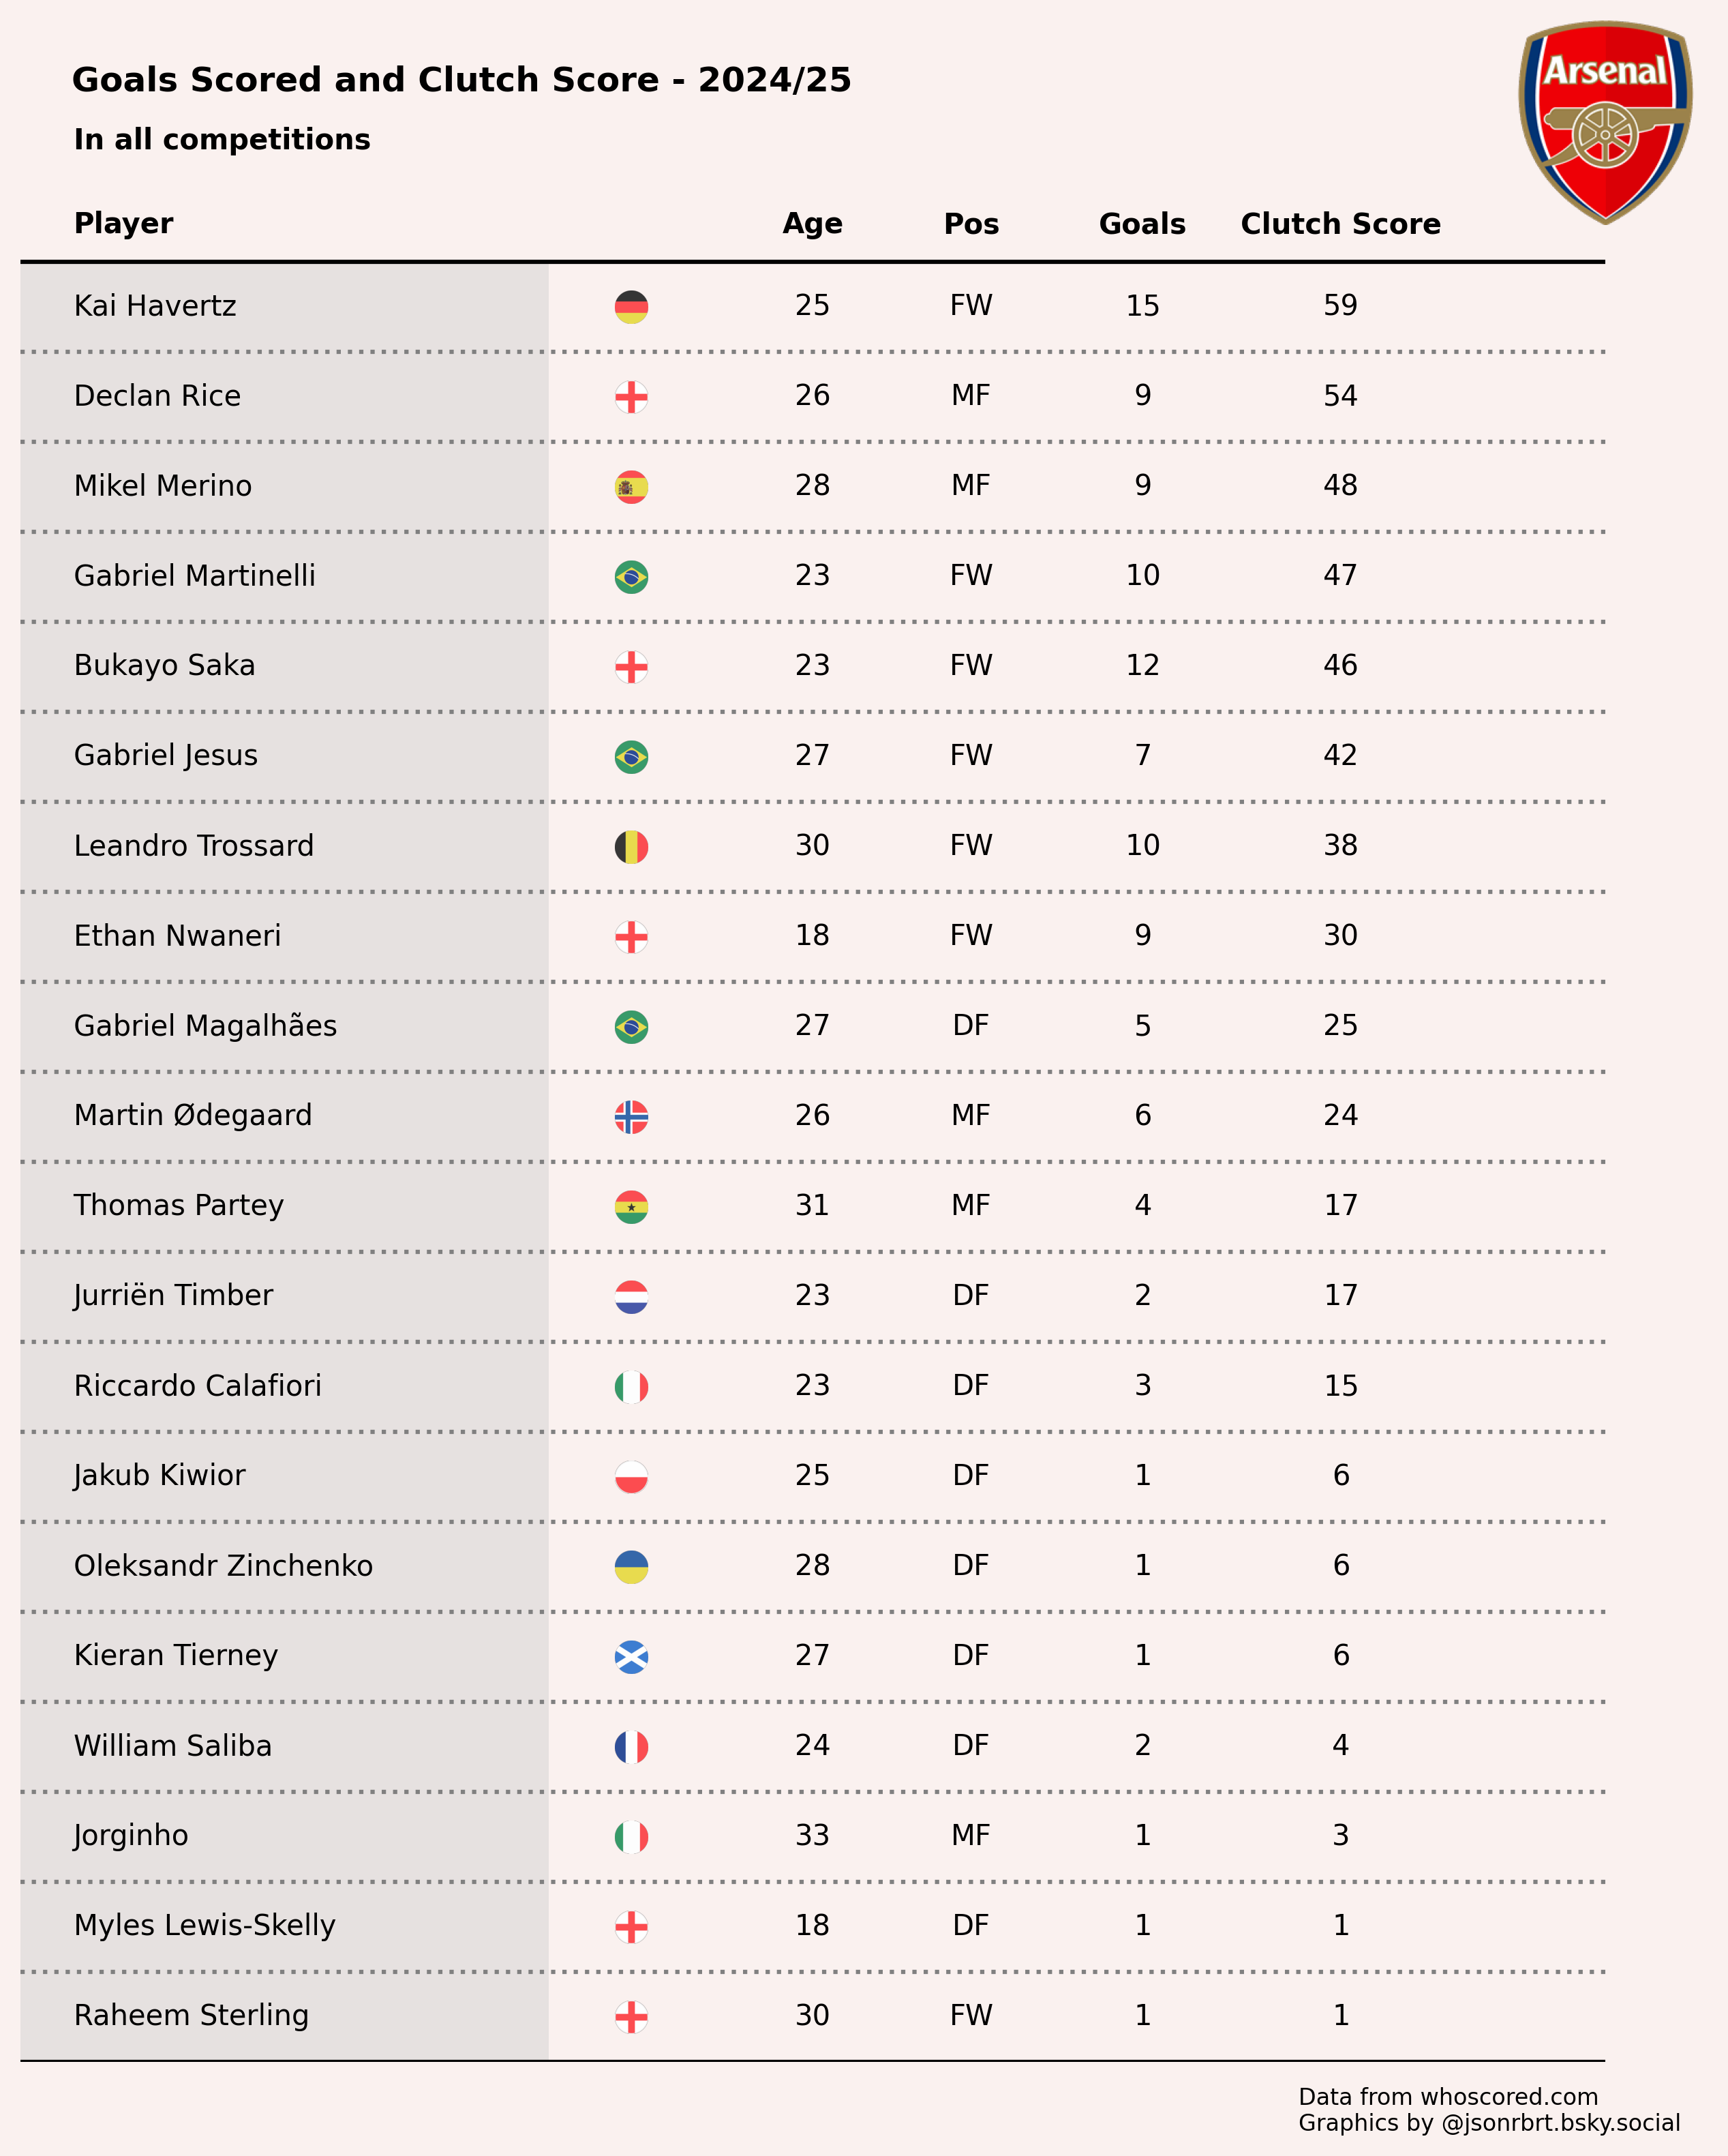

In [28]:
# Sort by clutch score in an ascending order
all_scorers = all_scorers.sort_values(by='clutch_score', ascending=True).reset_index(drop=True)

# Plot setup
fig = plt.figure(figsize=(10, 12), dpi=300, facecolor='#FAF1EF')
ax = plt.subplot()

ncols = 5
nrows = all_scorers.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

# Column positions and labels
positions = [0.2, 3, 3.6, 4.25, 5]
columns = ['name', 'age', 'position', 'goals', 'clutch_score']
column_names = ['Player', 'Age', 'Pos', 'Goals', 'Clutch Score']

# Add table text
for i in range(nrows):
    for j, column in enumerate(columns):
        ha = 'left' if j == 0 else 'center'
        text_label = f'{all_scorers[column].iloc[i]}'
        ax.annotate(
            xy=(positions[j], i + 0.5),
            text=text_label,
            ha=ha,
            va='center',
            weight='normal'
        )

# Coordinate transformation helpers
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

# Flags
flag_width_scale = 0.5
flag_height_scale = 0.5
ax_point_1 = DC_to_NFC([0.5, 0.5])
ax_point_2 = DC_to_NFC([0.25, 0.25])
ax_width = abs(ax_point_1[0] - ax_point_2[0]) * flag_width_scale
ax_height = abs(ax_point_1[0] - ax_point_2[0]) * flag_height_scale

for x in range(nrows):
    ax_coords = DC_to_NFC([2.25, x + 0.275])
    flag_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_width, ax_height])
    ax_logo(all_scorers['nationality'].iloc[x], flag_ax)

# Mini bar chart for goals
#ax_point_1 = DC_to_NFC([4, 0.05])
#ax_point_2 = DC_to_NFC([5, 0.95])
#bar_width = abs(ax_point_1[0] - ax_point_2[0])
#bar_height = abs(ax_point_1[1] - ax_point_2[1])

#for x in range(nrows):
    #ax_coords = DC_to_NFC([4.5, x + 0.025])
    #bar_ax = fig.add_axes([ax_coords[0], ax_coords[1], bar_width, bar_height])
    #bar_ax.barh(0, all_scorers['goals'].iloc[x], color='#EF0107')
    #bar_ax.set_xlim(0, all_scorers['goals'].max() + 1)
    #bar_ax.axis('off')

# Column headers
for index, col in enumerate(column_names):
    ha = 'left' if index == 0 else 'center'
    ax.annotate(
        xy=(positions[index], nrows + 0.25),
        text=col,
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Grid lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.5, color='gray', ls=':', zorder=3)

# Highlight name column
ax.fill_between(x=[0, 2], y1=nrows, y2=0, color='lightgrey', alpha=0.5, ec='None')

# Caption and footer
ax.text(x=0.2, y=21.25, s='In all competitions', weight='bold', color='black')
fig.text(x=0.75, y=0.08, s='Goals data from whoscored.com \nGraphics by @jsonrbrt.bsky.social',
         ha='left', va='bottom', weight='normal', size=8)

# Hide main axis
ax.set_axis_off()

# Arsenal logo and title
logo_ax = fig.add_axes([0.85, 0.85, .1, .1])
ax_logo(9825, logo_ax)
fig.text(x=0.15, y=0.91, s='Goals Scored and Clutch Score - 2024/25',
         ha='left', va='bottom', weight='bold', size=12)

In [30]:
# Export the chart to a PNG file
fig.savefig('visuals/clutch_score_table.png', dpi=300, bbox_inches='tight')